# Problem 1
In this problem, we will generate bivariate data from two normal distributions and classify the data using logistic regression. The function `modelFitVal` will fit and cross-validate the model. We will visualize the underlying distributions and the resulting decision boundary.

In [1]:
# import packages
%pylab inline
import scipy.stats
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


## Part 1: Sampling and Analyzing
We begin by specifying the parameters for generating the data: sample size, means, and covariance matrix.

In [2]:
# set sample size, means, and covariance matrix
nSamples = 500
mu_1 = [1, 3]
mu_2 = [3, 0]
sigma = [[ 2.0,  1.5],
         [ 1.5,  2.0]]

First, we generate the data using these parameters and an appropriate function, concatenate the two
sample populations, and create a vector of labels (ones for one population, zeros for the other)

In [3]:
# create distributions
dist1 = scipy.stats.multivariate_normal(mu_1, sigma)
dist2 = scipy.stats.multivariate_normal(mu_2, sigma)

# sample data from both distributions
X1 = dist1.rvs(nSamples)
X2 = dist2.rvs(nSamples)
X = vstack([X1, X2])

# create labels
L1 = ones(nSamples)
L2 = zeros(nSamples)
L = concatenate([L1, L2])

$n$ is the number of samples, $X$ will be a $2n\times 2$ matrix and $L$ will be of length $2n$.
Next, we want to see what the two underlying distributions look like along the two dimensions $x_1$
and $x_2$ (not to be confused with the two sample populations $X_1$ and $X_2$). Create a grid of $100\times100$
equidistant points within the bounds of the sample populations, using xVector, and compute the two
PDFs for each point.

In [4]:
# compute representative densities of underlying distributions
xVector = linspace(X.min(), X.max(), 100)
xx = transpose([tile(xVector, 100), repeat(xVector, 100)])
pDist = dist1.pdf(xx) + dist2.pdf(xx)
pDist = pDist.reshape(100, 100)

You might want to use the `meshgrid` function and reshape the resulting matrices to vectors. If you have trouble with the suggested one-liners, use for-loops instead. The result `pDist` should be a 100$\times$100 matrix containing the sum of both PDFs.

Now we train a logistic regression on the sample data, using the implementation that is included in the sklearn package. [[link]](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) We use it plain, without modifying any paramters. 

In [5]:
model = LogisticRegression()
model.fit(X, L)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

To display the decision boundary of the fitted model, we solve the iso-error problem, i.e. we compute the line on which $P(C_1\ |\ x) = P(C_2\ |\ x) = 0.5$. This means solving
$$0.5 = \sigma (w^Tx+w_0)$$
with $\sigma$ being the logistic function; $w=(w_1,w_2)$; $w_0$ is the intercept and $x=(x_1,x_2)$. We have to rewrite the equation for $x_2$ and set $x_1$ to `xVector`.

In [6]:
# determine the decision boundary of the fitted model
w0 = model.intercept_[0]
w1, w2 = model.coef_[0]
x2db = (-log(0.5) - w1*xVector - w0) / w2

Now we validate the fitted model (find the appropriate function!) on the same 100$\times$100 data points as before to get the posterior densities predicted by the model. (We only compute $P(C_1\ |\ x)$, since $P(C_2\ |\ x)=1-P(C_1\ |\ x)$.)

In [7]:
# compute representative class posteriors
posterior = model.predict_proba(xx)
posterior_C1 = posterior[:, 0]
posterior_C1 = posterior_C1.reshape(100, 100)

# Part 2: Classification
The function `modelFitVal` should take a data matrix (samples $\times$ dimensions), a correpsonding label vector, and the number of partitions, then iteratively divide the data and labels into training sets and test sets, fit and validate the logistic regression, and return the mean percentage of correctly predicted labels.

**a)** First, we create a random permutation of the sample indices, which we will use when composing the partitions.

```python
nSamples = size(X, 1);
randIdx = ...
```

This way we avoid order effects on model performance but still create disjoint partitions. With our random data, order doesn't matter, but will in the later problems.

**b)** In the subsequent loop we divide the data and labels into test and training sets. From `rand_idx` we select $\frac{\texttt{nSamples}}{\texttt{k}}$ indices for testing and the remaining $\frac{(\texttt{k}-1)\ \cdot\ \texttt{nSamples}}{\texttt{k}}$ indices for training.

Note that `nSamples` need not be a multiple of `k`. Make sure that the size of test sets (same for training sets) does not differ by more than 1 across partitions. Make also sure that all samples are used for testing exactly once.

**c)** Now we fit the model as before and compare the validation output, i.e. the predicted labels for the test data, to the actual labels. The percentage of correct predictions is then accumulated over iterations.

In [8]:
def modelFitVal(X, L, kPart):
    """
    modelFitVal takes multivariate data (one feature per column) and
    associated labels and returns the cross-validated performance of a linear
    model.

    """
    # a)
    # set up shuffled data partitions
    nSamples = len(X)
    rand_idx = permutation(nSamples) % kPart

    pCorrect = 0

    for iPart in range(kPart):

        # b)
        # separate training and test data
        test_idx = (rand_idx == iPart)
        train_idx = ~test_idx
        
        xTest = X[test_idx]
        lTest = L[test_idx]
        xTrain = X[train_idx]
        lTrain = L[train_idx]
        
        # c)
        # fit model to training data using logistic regressio
        model = LogisticRegression()
        model.fit(xTrain, lTrain)

        # compute p(C1|D) for test data
        posterior_C1 = model.predict(xTest)

        # compare model's classification to actual labels
        pCorrect += mean(posterior_C1 == lTest) / kPart

    return pCorrect

Now use your model do get the valiadation error of a ten fold crossvalidation.

In [9]:
# cross-validate the same model to estimate generalization
kCross = 10
pCorrect = modelFitVal(X, -1*L, kCross)

## Part 3: Plotting and Exploring
Your code should print the model's average classification performance and produce the two figures below, showing the sample data with their underlying distributions and the model's decision boundary, and the class posterior probabilities, respectively.

[Scatter Data + Decision boundary](p1fig1.png),
[C1 posterior](p1fig2.png)


Note that the plots will vary a bit at between runs because of the randomness in sampling and cross-validation. Classification performance should be at or near 100%. You may want to try different distribution parameters and sample sizes and see how performance and plots change. Try to understand the warning messages you might get.


Performance: 99.0 percent




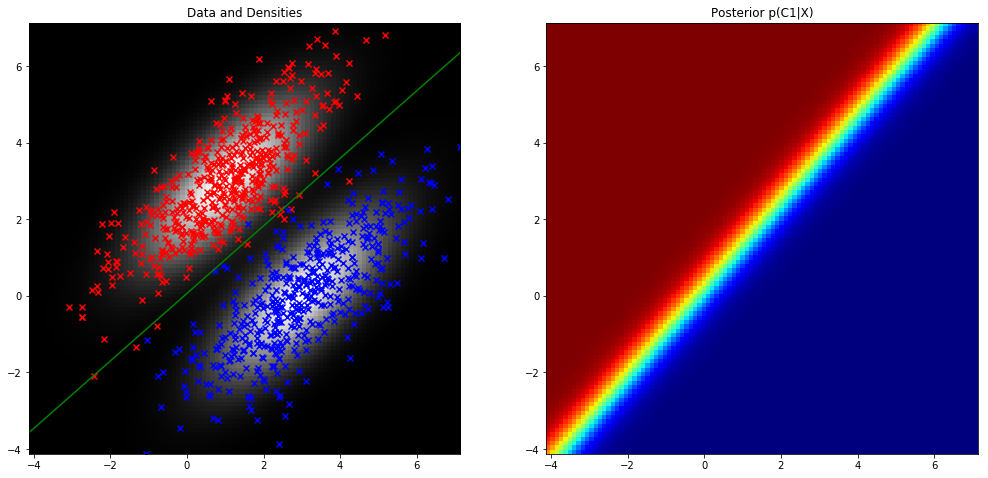

In [10]:
# plot data, distributions, and decision boundary
figure(figsize=[17,8])
subplot(121)
imshow(rot90(pDist.T), extent=(X.min(), X.max())*2, cmap='gray')
scatter(*X1.T, color='red', marker='x')
scatter(*X2.T, color='blue', marker='x')
plot(xVector, x2db, color='green')
ylim((X.min(), X.max()))
xlim((X.min(), X.max()))
title('Data and Densities')

# plot posterior C1
subplot(122)
imshow(rot90(posterior_C1), extent=(X.min(), X.max())*2, cmap='jet')
ylim(X.min(), X.max()); xlim(X.min(), X.max())
title('Posterior p(C1|X)')

# print performance
print('\nPerformance: %s percent\n\n' % round(100*pCorrect))